In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle

from scipy.optimize import fsolve
from scipy.optimize import differential_evolution
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

from PySpice.Spice.Netlist import Circuit
import PySpice.Logging.Logging as Logging
from PySpice.Unit import *

from CC4_PreAmplifier import *
from signals import *

from tqdm.notebook import tqdm

plt.rcParams.update({
    'font.size': 12,          # Default text size
    'axes.titlesize': 14,     # Title size
    'axes.labelsize': 12,     # Axis label size
    'xtick.labelsize': 10,    # X-tick label size
    'ytick.labelsize': 10,    # Y-tick label size
    'legend.fontsize': 11     # Legend size
})

In [2]:
T_operating = 89

# cascode params
V_DD = 11.7     # Supply voltage [V]
R_L = 1.6e3     # Load resistor  [Ohm]
V_G2 = 4.5      # Bias voltage for Q2's gate [V]

# feedback params
R_f = 1e9
C_f = 400e-15

ADC_to_V = 0.13/(20e3)
V_to_ADC = 1/ADC_to_V
print('ADC to V:',round(ADC_to_V,7))

ADC to V: 6.5e-06


In [3]:
def preprocess_dataframe(df):

    # Conversion factor from ADC to Volts
    ADC_to_V = 0.13/(20e3)
    
    # Create lists to store processed data
    scans = []
    signal_V_list = []
    time_signal_ns_list = []
    waveform_V_list = []
    time_waveform_ns_list = []
    time_stamp_signal_list = []
    time_stamp_waveform_list = []
    
    # Process each row
    for idx, row in df.iterrows():
        scan = row['scan']
        scans.append(scan)
        
        # Process signal data
        signal = np.array(row['signal'])
        time_windowed_signal = np.array(row['time_signal'])
        
        # Calculate offset from first 20% of signal data
        offset_idx = int(len(signal) * 0.2)
        offset = np.mean(signal[:offset_idx])
        
        # Remove offset and convert from ADC to V
        processed_signal = (signal - offset) * ADC_to_V
        
        # Convert time to start from 0 and convert to ns
        time_start = time_windowed_signal[0]
        processed_time_signal = (time_windowed_signal - time_start)
        
        # Process waveform data
        waveform = np.array(row['waveform'])
        time_windowed_waveform = np.array(row['time_waveform'])
        
        # Calculate offset from first 10% of waveform data
        offset_idx_wf = int(len(waveform) * 0.1)
        offset_wf = np.mean(waveform[:offset_idx_wf])
        
        # Remove offset and convert from ADC to V
        processed_waveform = (waveform - offset_wf) * ADC_to_V
        
        # Convert time to start from 0 and convert to ns
        time_start_wf = time_windowed_waveform[0]
        processed_time_waveform = (time_windowed_waveform - time_start_wf)  
        
        # Store processed data in lists
        signal_V_list.append(processed_signal.tolist())
        time_signal_ns_list.append(processed_time_signal.tolist())
        waveform_V_list.append(processed_waveform.tolist())
        time_waveform_ns_list.append(processed_time_waveform.tolist())
        time_stamp_signal_list.append(row['time_stamp_signal'])
        time_stamp_waveform_list.append(row['time_stamp_waveform'])
    
    # Create a new DataFrame all at once
    processed_df = pd.DataFrame({
        'scan': scans,
        'time_stamp_signal': time_stamp_signal_list,
        'signal': signal_V_list,
        'time_signal': time_signal_ns_list,
        'time_stamp_waveform': time_stamp_waveform_list,
        'waveform': waveform_V_list,
        'time_waveform': time_waveform_ns_list,
    })
    
    return processed_df


def sigmoid(t, A, k, t0, B):
    return A / (1 + np.exp(-k * (t - t0))) + B


def sort_by_waveform_amplitude(processed_df):
    # Create a copy of the processed DataFrame
    sorted_df = processed_df.copy()
    
    # List to store the amplitude values
    amplitudes = []
    var_amplitudes = []
    
    # Fit sigmoid to each waveform and extract the amplitude
    for idx, row in processed_df.iterrows():
        waveform = np.array(row['waveform'])
        time = np.array(row['time_waveform'])
        
        try:
            # Initial parameter guesses
            # A: estimate from max-min of waveform
            # k: moderate steepness
            # t0: midpoint of time range
            # B: minimum value of waveform
            p0 = [
                np.max(waveform) - np.min(waveform),  # A: amplitude guess
                0.1,                                   # k: steepness guess
                np.median(time),                       # t0: midpoint guess
                np.min(waveform)                       # B: offset guess
            ]
            
            # Set bounds to help convergence
            bounds = (
                [0, 0, np.min(time), -np.inf],          # Lower bounds
                [np.inf, np.inf, np.max(time), np.inf]  # Upper bounds
            )
            
            # Perform the fit
            popt, pcov = curve_fit(sigmoid, time, waveform, p0=p0, bounds=bounds, maxfev=10000)
            
            # Extract the amplitude (parameter A)
            amplitude = popt[0]
            amplitude_var = pcov[0][0]
            
        except Exception as e:
            print(f"Fitting failed for scan {row['scan']}: {e}")
            # Assign a default amplitude if fitting fails
            amplitude = 0
            amplitude_var = 0
        
        amplitudes.append(amplitude)
        var_amplitudes.append(amplitude_var)
    
    # Add the amplitude and variance columns to the DataFrame
    sorted_df['waveform_amplitude'] = amplitudes
    sorted_df['waveform_amplitude_var'] = var_amplitudes
    
    # Sort the DataFrame by amplitude
    sorted_df = sorted_df.sort_values(by='waveform_amplitude')
    
    # Reset the index
    sorted_df = sorted_df.reset_index(drop=True)
    
    return sorted_df

In [4]:
# crate a list of files names
data_path = '/Users/raffaelegaudio/Desktop/Tesi_Magistrale/simulazioni/energy_scans_pulser/'

signals = []
waveforms = []

for id in range(14):
    signal = data_path+'pulser_signal_p11_r006_'+str(id)+'.json' 
    signals.append(signal)

for id in range(14):
    waveform = data_path+'mean_pulser_wf_all_ICPC_p11_r006_'+str(id)+'.json' 
    waveforms.append(waveform)


# create dictionaries to store the data
signal_data = {}
waveform_data = {}

for i, file_path in enumerate(signals):
    with open(file_path, 'r') as file:
        signal_data[f'scan_{i}'] = json.load(file)

for i, file_path in enumerate(waveforms):
    with open(file_path, 'r') as file:
        waveform_data[f'scan_{i}'] = json.load(file)


# create a dataframe with all the data
df_data = []

for i in range(14):
    row_data = {
        'scan': i,
        'time_stamp_signal': signal_data[f'scan_{i}']['time_stamp'],
        'signal': signal_data[f'scan_{i}']['signal'],
        'time_signal': signal_data[f'scan_{i}']['time_windowed'],

    }

    row_data['time_stamp_waveform'] = waveform_data[f'scan_{i}']['time_stamp'] 
    row_data['waveform'] = waveform_data[f'scan_{i}']['signal']
    row_data['time_waveform'] = waveform_data[f'scan_{i}']['time_windowed']

    df_data.append(row_data)

# Create the DataFrame
df = pd.DataFrame(df_data)

# Voltage conversion and time rescaling-----------------------------------------------------------------
processed_df = preprocess_dataframe(df)

# Attenuation factors-----------------------------------------------------------------------------------
def ratio(attenaution_db):
    return 10**(-attenaution_db/20.0)

attenuations_db = np.array([52,42,38,35,32,28,26,24,23,21,20,19,18,17])
ratios = np.array([ratio(i) for i in attenuations_db])


# Sort by waveform amplitue and apply attenuation function
sorted_df = sort_by_waveform_amplitude(processed_df)
scaled_df = sorted_df.copy()

# Apply the scaling to each row
for i in range(len(ratios)):
    # Make sure i is in range of both the DataFrame and ratios array
    if i < len(scaled_df) and i < len(ratios):
        scaled_df.at[i, 'signal'] = [val * ratios[i] for val in scaled_df.at[i, 'signal']]

scaled_df

/var/folders/0d/wr4vslms6rx70gkgwp1_dz400000gn/T/ipykernel_27100/1621788783.py:73: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-k * (t - t0))) + B


,scan,time_stamp_signal,signal,time_signal,time_stamp_waveform,waveform,time_waveform,waveform_amplitude,waveform_amplitude_var
0,12,1.716273e+09,"[4.315062048411276e-09, 3.696958565803581e-08,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[3.760714285713948e-05, 3.110714285713948e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.004638,1.512630e-11
1,1,1.716273e+09,"[2.6424179794069536e-07, -3.5533422514424417e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[7.707142857137115e-06, 1.2071428571371145e-06...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.014515,1.341216e-10
2,2,1.716273e+09,"[4.120732642532984e-08, -4.062282534129105e-08...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[-3.8164285714286054e-05, -5.7664285714286054e...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.022909,3.253645e-10
3,8,1.716272e+09,"[3.6657959838365994e-07, -5.581256948365801e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.771071428571395e-05, 5.121071428571395e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.032431,6.397754e-10
4,5,1.716272e+09,"[-7.574683244446494e-07, -1.0437785225215877e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.4460714285713954e-05, 6.746071428571396e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.045656,1.416528e-09
5,13,1.716272e+09,"[-4.620886801066035e-07, 1.6080686067715828e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[1.5042857142862886e-05, 4.754285714286289e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.072507,3.377835e-09
6,3,1.716272e+09,"[1.0843543790409398e-06, -1.847590937678603e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-1.8385714285718678e-05, -3.788571428571868e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.091233,5.529557e-09
7,7,1.716272e+09,"[2.6072058841550167e-07, 6.708428623276273e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-8.171428571427897e-06, -1.6714285714278958e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.114635,8.766474e-09
8,10,1.716271e+09,"[1.3476253681308756e-06, 4.27295848431496e-07,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[4.039285714286052e-06, -1.5460714285713948e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.128655,1.036040e-08
9,9,1.716271e+09,"[1.7606980586735308e-06, 6.020718390996616e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[5.065357142856738e-05, 6.365357142856738e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.161716,1.578049e-08


In [30]:
scaled_df.to_pickle('pulser_dataframe.pkl')

In [27]:
scaled_df["signal"][0]

[4.315062048411276e-09,
 3.696958565803581e-08,
 4.315062048411276e-09,
 5.329684746284808e-08,
 -6.099398517083779e-08,
 5.329684746284808e-08,
 -7.732124697565006e-08,
 5.329684746284808e-08,
 -6.099398517083779e-08,
 5.329684746284808e-08,
 -6.099398517083779e-08,
 1.0227863287728488e-07,
 -1.201219975640099e-08,
 -2.833946156121326e-08,
 3.696958565803581e-08,
 8.595137107247261e-08,
 -1.201219975640099e-08,
 4.315062048411276e-09,
 -4.466672336602552e-08,
 6.962410926766035e-08,
 5.329684746284808e-08,
 -6.099398517083779e-08,
 -4.466672336602552e-08,
 5.329684746284808e-08,
 2.064232385322354e-08,
 5.329684746284808e-08,
 3.696958565803581e-08,
 2.064232385322354e-08,
 6.962410926766035e-08,
 -4.466672336602552e-08,
 1.1860589468209715e-07,
 2.064232385322354e-08,
 8.595137107247261e-08,
 4.315062048411276e-09,
 1.1860589468209715e-07,
 2.064232385322354e-08,
 8.595137107247261e-08,
 -1.099757705852746e-07,
 2.064232385322354e-08,
 2.064232385322354e-08,
 -1.201219975640099e-08,


In [5]:
def plot_signal_and_waveform(df, scan_number, display_scan=False):

    row = df[df['scan'] == scan_number].iloc[0]
    
    signal = row['signal']
    time_windowed_signal = row['time_signal']
    time_stamp_signal = row['time_stamp_signal']

    waveform = row['waveform']
    time_windowed_waveform = row['time_waveform']
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    if display_scan:
        fig.suptitle(f'[Scan: {scan_number}, Timestamp: {time_stamp_signal}]' )
    else:
        fig.suptitle(f'[Timestamp: {time_stamp_signal}]' )

    if isinstance(signal, (list, np.ndarray)):
        axs[0].plot(time_windowed_signal, signal)
    else:
        axs[0].plot(signal)
    
    axs[0].set_title(f'Input Signal')
    axs[0].set_xlabel('Time [ns]')
    axs[0].set_ylabel('Voltage [V]')
    axs[0].set_ylim([-0.0035, 0.05])
    axs[0].grid(alpha=0.5)
    
    if isinstance(waveform, (list, np.ndarray)):
        axs[1].plot(time_windowed_waveform, waveform)
    else:
        # Adjust as needed based on your data structure
        axs[1].plot(waveform)
    
    axs[1].set_title(f'Mean Waveform')
    axs[1].set_xlabel('Time [ns]')
    axs[1].set_ylabel('Voltage [V]')
    axs[1].set_ylim([-0.015, 0.23])
    axs[1].grid(alpha=0.5)
    
    plt.tight_layout()

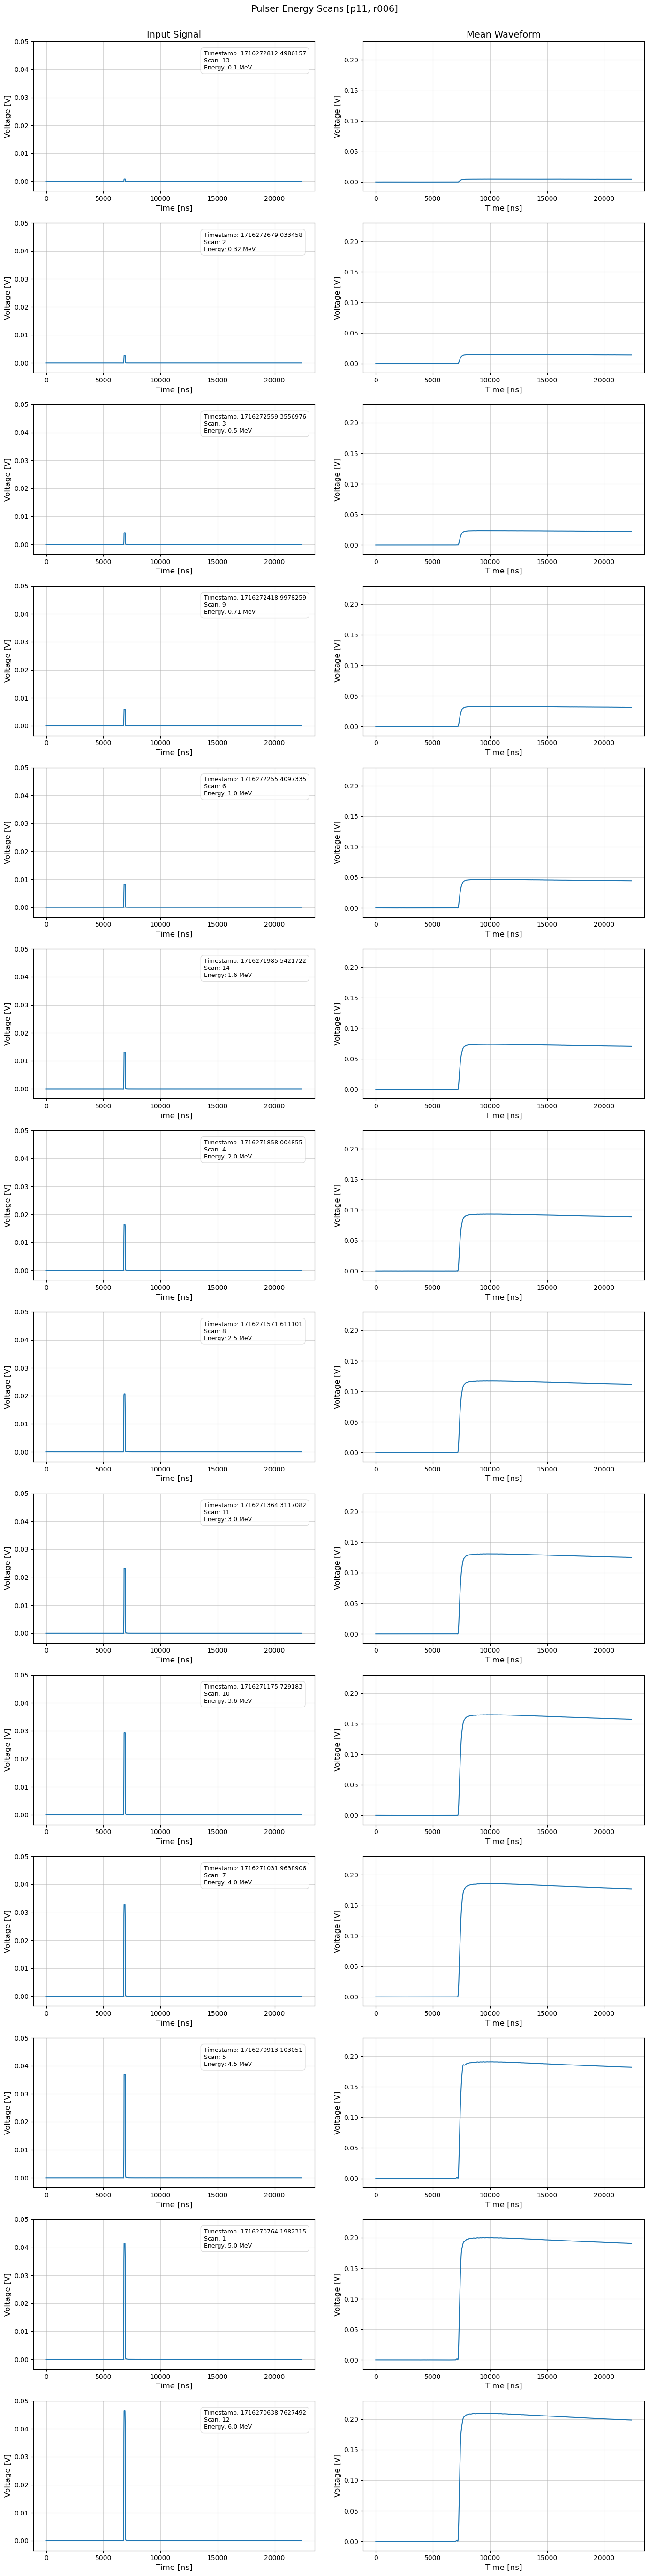

In [6]:
num_rows = len(scaled_df)
energies = np.array([0.1,0.32,0.5,0.71,1.0,1.6,2,2.5,3,3.6,4,4.5,5,6])


fig, axs = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
fig.suptitle('Pulser Energy Scans [p11, r006]', fontsize=14)
plt.subplots_adjust(top=0.98)

for i,j in enumerate(energies):

    if i == 0:
        axs[i, 0].set_title(f'Input Signal')

    axs[i, 0].plot(scaled_df.iloc[i]['time_signal'], scaled_df.iloc[i]['signal'])    
    axs[i, 0].set_xlabel('Time [ns]')
    axs[i, 0].set_ylabel('Voltage [V]')
    axs[i, 0].set_ylim([-0.0035, 0.05])
    axs[i, 0].grid(alpha=0.5)
    axs[i, 0].text(13800, 0.04, f'Timestamp: {scaled_df.iloc[i]["time_stamp_signal"]}\nScan: {scaled_df.iloc[i]["scan"]+1}\nEnergy: {j} MeV', 
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="lightgray", boxstyle="round,pad=0.5", alpha=0.8))
    

    if i == 0:
        axs[i, 1].set_title(f'Mean Waveform')
    axs[i, 1].plot(scaled_df.iloc[i]['time_waveform'], scaled_df.iloc[i]['waveform'])
    axs[i, 1].set_xlabel('Time [ns]')
    axs[i, 1].set_ylabel('Voltage [V]')
    axs[i, 1].set_ylim([-0.015, 0.23])
    axs[i, 1].grid(alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.98])



--------

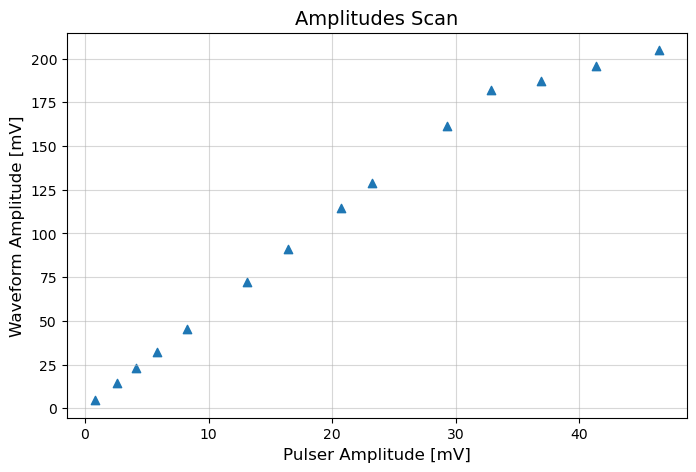

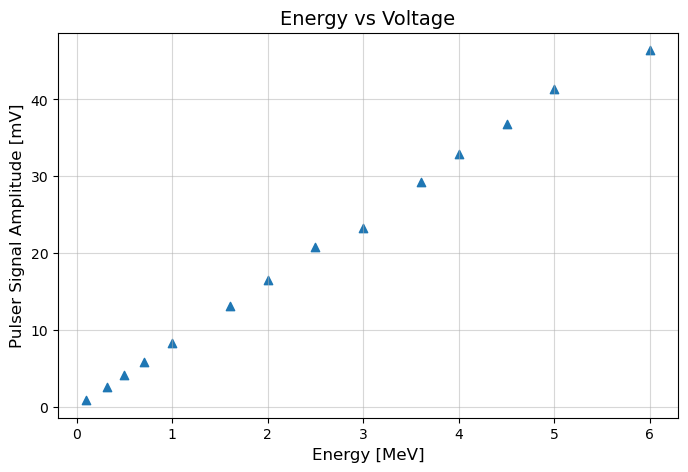

In [7]:
amplitude_signal = []
for signal in scaled_df['signal']:
    min_signal = np.mean(signal[:int(0.2 * len(signal))])  # Average over first 20%
    max_signal = np.max(signal)  # Maximum value
    amplitude_signal.append(max_signal - min_signal)

signal_amplitude=np.array(amplitude_signal)
waveform_amplitude=np.array([i for i in scaled_df['waveform_amplitude']])
waveform_amplitude_var=np.array([i for i in scaled_df['waveform_amplitude_var']])
waveform_amplitude_err = np.sqrt(waveform_amplitude_var)


plt.figure(figsize=(8,5))
plt.title('Amplitudes Scan')
plt.scatter(signal_amplitude*1e3, waveform_amplitude*1e3,  marker='^')
plt.xlabel('Pulser Amplitude [mV]')
plt.ylabel('Waveform Amplitude [mV]')
plt.grid(alpha=0.5)


energies = np.array([0.1,0.32,0.5,0.71,1.0,1.6,2,2.5,3,3.6,4,4.5,5,6])

plt.figure(figsize=(8,5))
plt.title('Energy vs Voltage')
plt.scatter(energies,signal_amplitude*1e3, marker='^')
plt.ylabel('Pulser Signal Amplitude [mV]')
plt.xlabel('Energy [MeV]')
plt.grid(alpha=0.5)

Gain of the linear region: 5.52619204124274 +/- 9.904873591433208e-06
Gain of the saturation region: 1.732191987945559 +/- 0.008506063860698949


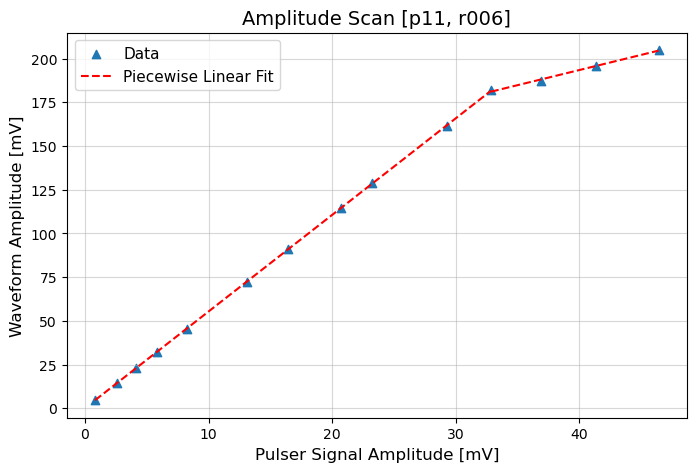

In [8]:
signal_amplitude
signal_amplitude_filtred = signal_amplitude[:-3]
waveform_amplitude_filtred = waveform_amplitude[:-3]

signal_amplitude_tail = signal_amplitude[10:]
waveform_amplitude_tail = waveform_amplitude[10:]


def linear_fit(x, A, B):
    return A*x + B

popt, pcov = curve_fit(linear_fit,signal_amplitude_filtred,waveform_amplitude_filtred)
lin_gain = popt[0]

popt1, pcov1 = curve_fit(linear_fit,signal_amplitude_tail,waveform_amplitude_tail)
sat_gain = popt1[0]

print(f'Gain of the linear region: {lin_gain} +/- {pcov[0,0]}')
print(f'Gain of the saturation region: {sat_gain} +/- {pcov1[0,0]}')

plt.figure(figsize=(8,5))
plt.scatter(signal_amplitude*1e3, waveform_amplitude*1e3,  marker='^', label='Data')
plt.plot(signal_amplitude_filtred*1e3,linear_fit(signal_amplitude_filtred, *popt)*1e3, 'r--', label='Piecewise Linear Fit')
plt.plot(signal_amplitude_tail*1e3,linear_fit(signal_amplitude_tail, *popt1)*1e3, 'r--')
plt.title('Amplitude Scan [p11, r006]')
plt.xlabel('Pulser Signal Amplitude [mV]')
plt.ylabel('Waveform Amplitude [mV]')
plt.grid(alpha=0.5)
plt.legend();

Text(0.5, 0, 'Energy [MeV]')

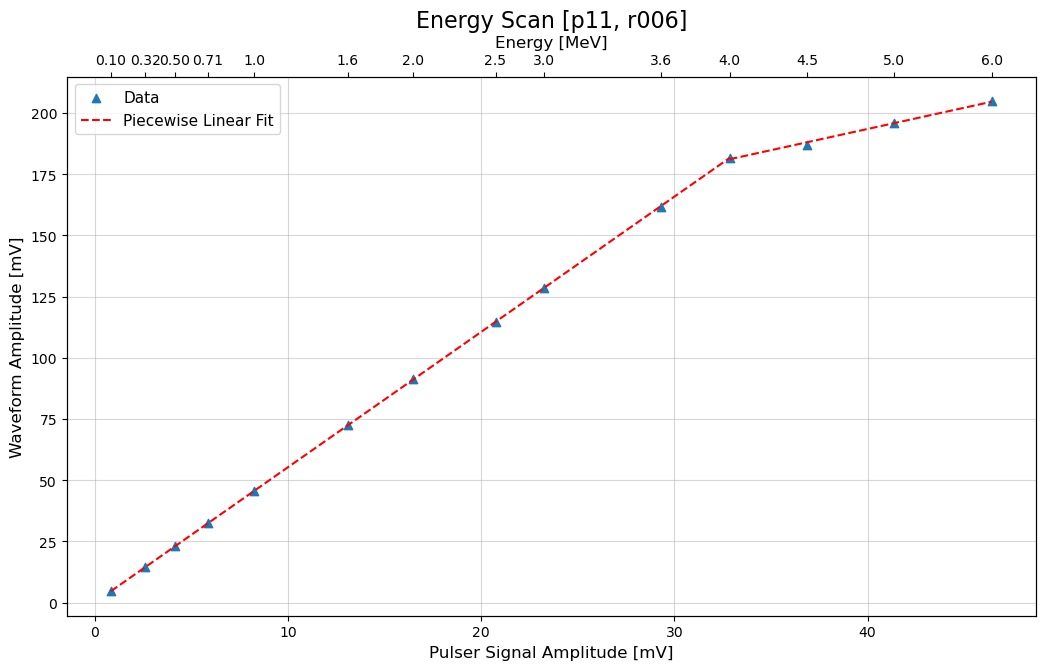

In [9]:
plt.figure(figsize=(12.5,7))

# Set font sizes
plt.rcParams.update({
    'font.size': 12,          # Default text size
    'axes.titlesize': 14,     # Title size
    'axes.labelsize': 12,     # Axis label size
    'xtick.labelsize': 10,    # X-tick label size
    'ytick.labelsize': 10,    # Y-tick label size
    'legend.fontsize': 11     # Legend size
})
title_size = 16

# Main plot
ax1 = plt.gca()  # Get current axis
plt.scatter(signal_amplitude*1e3, waveform_amplitude*1e3, marker='^', label='Data')
plt.plot(signal_amplitude_filtred*1e3, linear_fit(signal_amplitude_filtred, *popt)*1e3, 'r--', label='Piecewise Linear Fit')
plt.plot(signal_amplitude_tail*1e3, linear_fit(signal_amplitude_tail, *popt1)*1e3, 'r--')
plt.title('Energy Scan [p11, r006]', fontsize=title_size)
plt.xlabel('Pulser Signal Amplitude [mV]')
plt.ylabel('Waveform Amplitude [mV]')
plt.grid(alpha=0.5)
plt.legend()

# Create secondary x-axis at the top
ax2 = ax1.twiny()

# Energy values in MeV
energies = np.array([0.1, 0.32, 0.5, 0.71, 1.0, 1.6, 2, 2.5, 3, 3.6, 4, 4.5, 5, 6])  # MeV

# Direct mapping: energy values correspond to the signal amplitude data points
# Use the actual signal amplitude values (in mV) as tick positions
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(signal_amplitude*1e3)  # Use your actual signal amplitude values in mV
ax2.set_xticklabels([f'{e:.2f}' if e < 1 else f'{e:.1f}' for e in energies])
ax2.set_xlabel('Energy [MeV]')

#plt.tight_layout()

In [10]:
def integrate_signal_2(R_f, C_f, input_signal, dt, decay=True):
    tau = R_f * C_f             
    offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
    output_signal = np.zeros_like(input_signal)
    effective_signal = input_signal - offset  

    if decay:
        decay_factor = np.exp(-dt /tau)
    else: decay_factor = 1

    for i in range(1, len(input_signal)):
        input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
        output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
    
    return -output_signal 

In [11]:
with open('total_transfer_function_params.pkl', 'rb') as f:
    total_transfer_loaded = pickle.load(f)

In [12]:
def validation_test(idx, dc_bias, verbose=False):
    test_signal = np.array([i for i in scaled_df['signal'][idx]])
    test_signal_time = np.array([i*1e-9 for i in scaled_df['time_signal'][idx]])
    test_waveform = np.array([i for i in scaled_df['waveform'][idx]])
    test_waveform_time = np.array([i*1e-9 for i in scaled_df['time_waveform'][idx]])
    test_timestamp = scaled_df['time_stamp_signal'][idx]

    dt_signal = test_signal_time[1]-test_signal_time[0]

    dc_bias = dc_bias
    test_signal_biased = np.array([i+dc_bias for i in test_signal])

    test_signal_out = total_transfer_loaded(test_signal_biased)
    simulated_waveform = integrate_signal_2(R_f=1e9,C_f=400e-15,input_signal=test_signal_out,dt=dt_signal)


    simulated_waveform_amplitude = np.max(simulated_waveform)-np.mean(simulated_waveform[:int(len(simulated_waveform)*0.2)])
    test_waveform_amplitude = sorted_df['waveform_amplitude'][idx]

    conv_factor = test_waveform_amplitude/simulated_waveform_amplitude

    if verbose:
        print(f'Simulated Waveform Amplitude: {simulated_waveform_amplitude}')
        print(f'Real Waveform Amplitude: {test_waveform_amplitude}')
        print(f'Conversrion Factor: {conv_factor}\n')

    simulated_waveform_converted = np.array([i*conv_factor for i in simulated_waveform])


    plt.figure(figsize=(13,4))
    plt.suptitle(f'[Timestamp: {test_timestamp}]')

    plt.subplot(1,2,1)
    plt.title('Input Signal')
    plt.plot(test_signal_time*1e9,test_signal)
    plt.xlabel('Time [ns]')
    plt.ylabel('Voltage [V]')
    plt.grid(alpha=0.5)

    plt.subplot(1,2,2)
    plt.title('Output Signal')
    plt.plot(test_signal_time*1e9,simulated_waveform_converted, label='Simulated Waveform')
    plt.plot(test_waveform_time*1e9,test_waveform, label='Mean Waveform')
    plt.legend()
    plt.xlabel('Time [ns]')
    plt.ylabel('Voltage [V]')
    plt.grid(alpha=0.5)
    plt.tight_layout()

    return simulated_waveform_converted, simulated_waveform_amplitude, test_waveform_amplitude, conv_factor


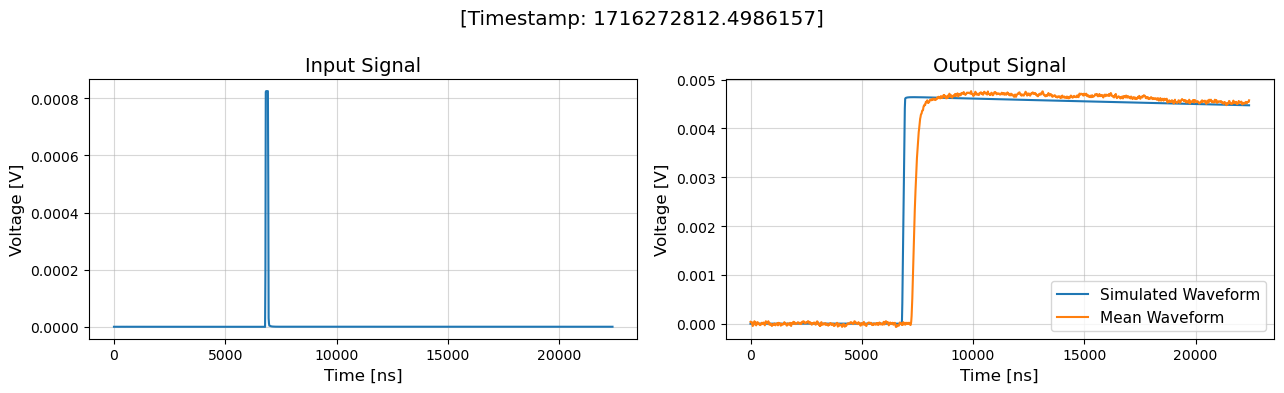

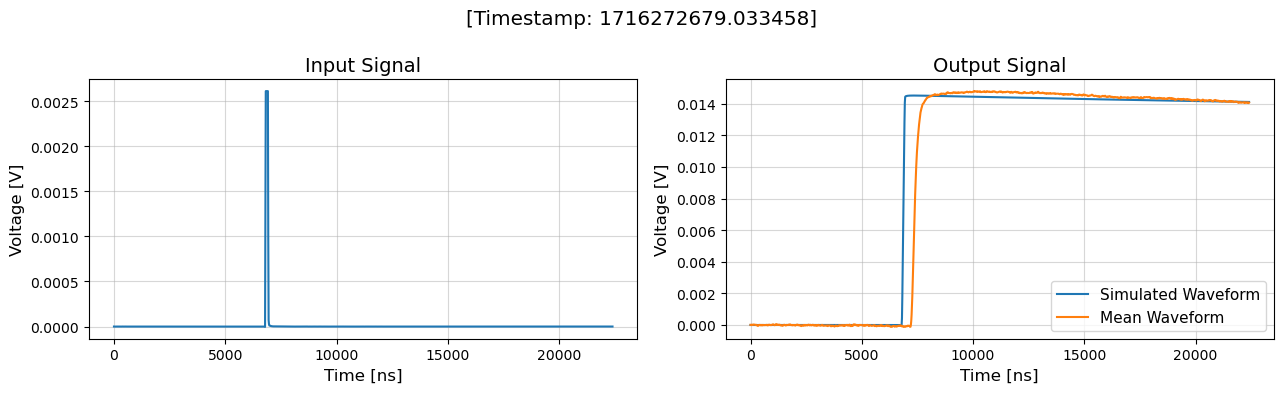

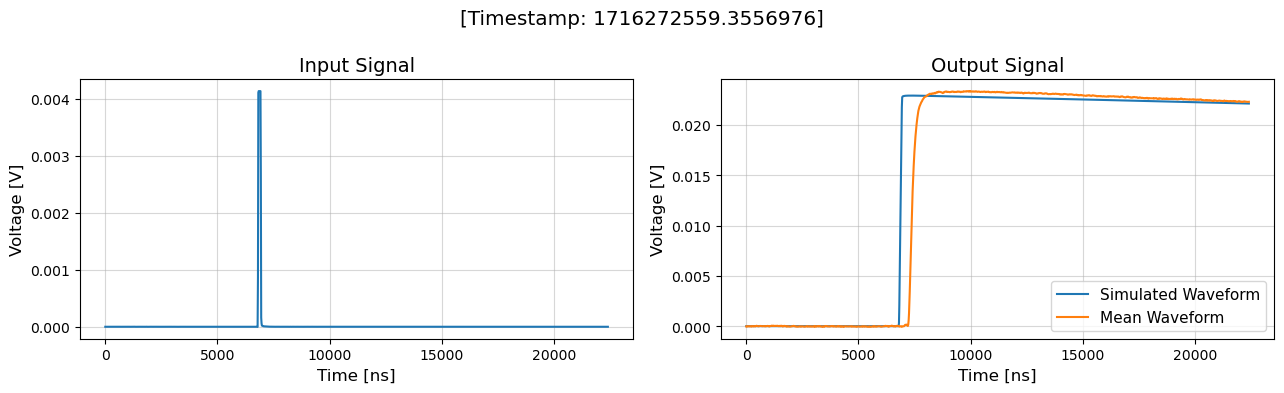

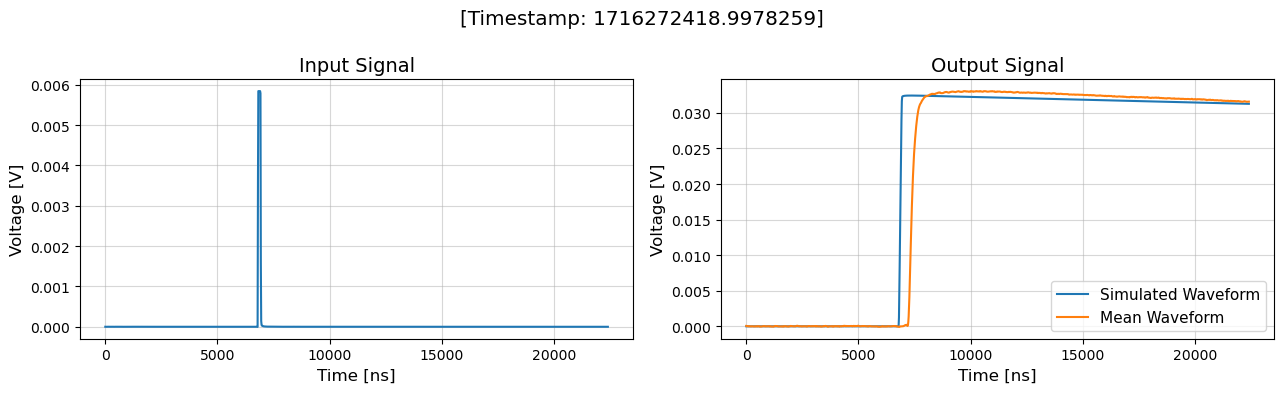

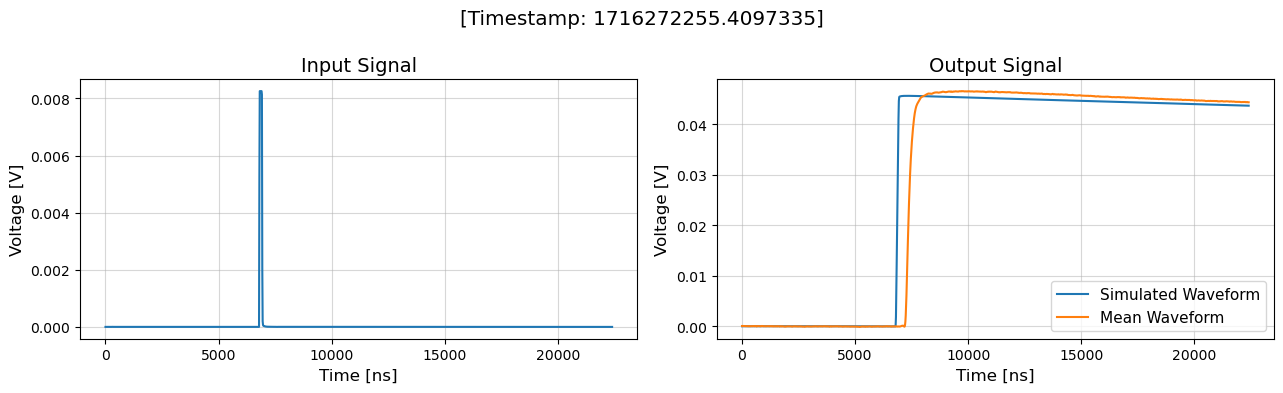

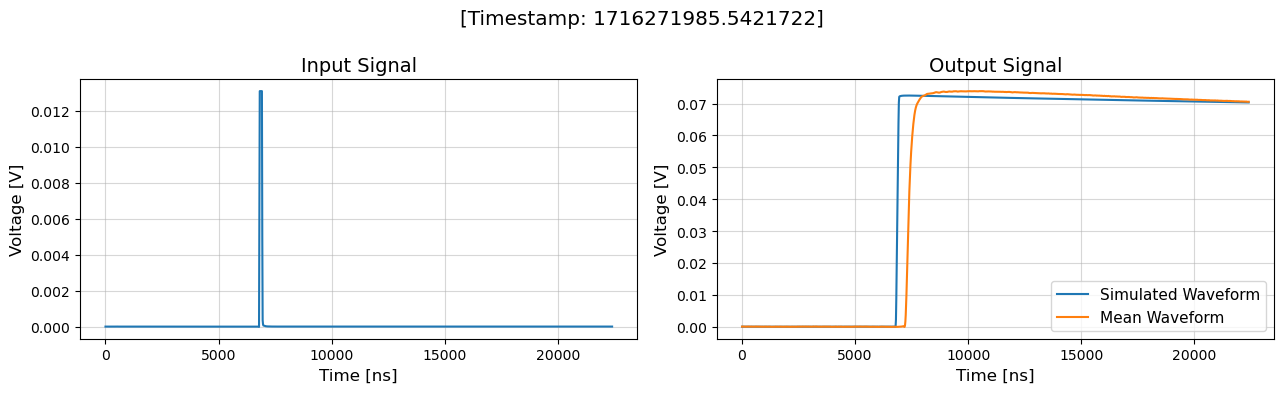

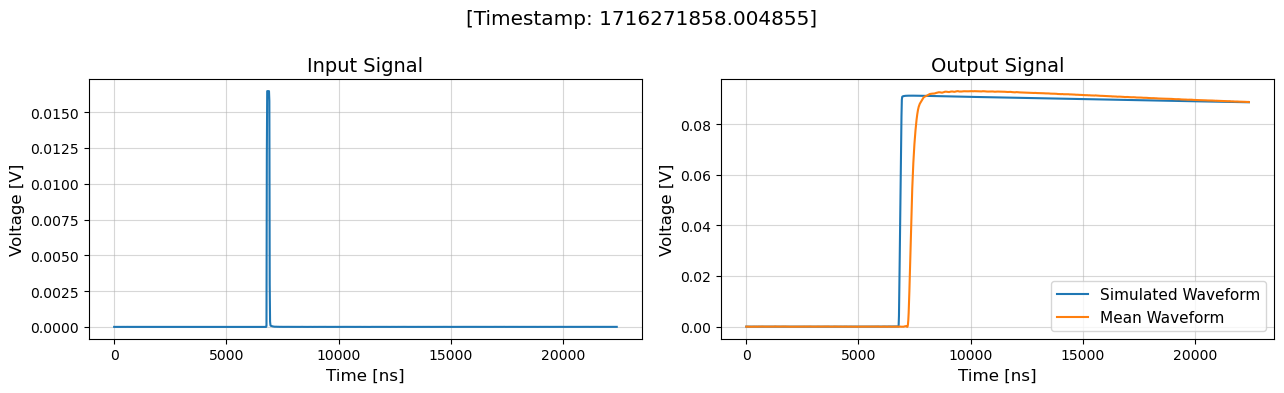

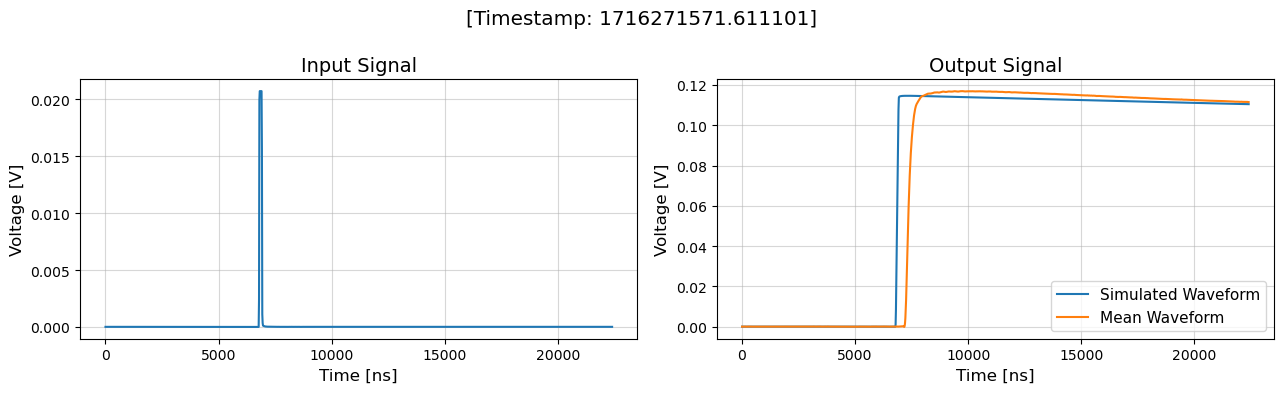

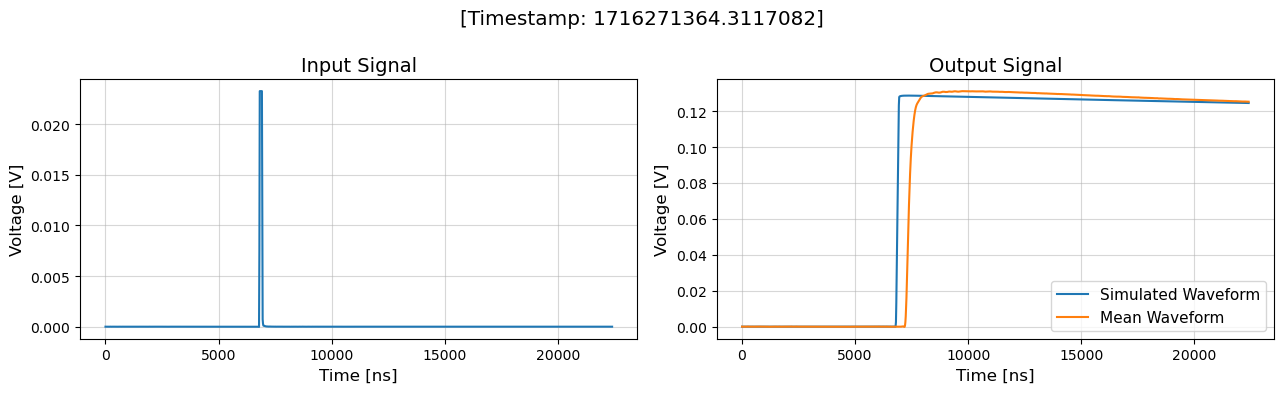

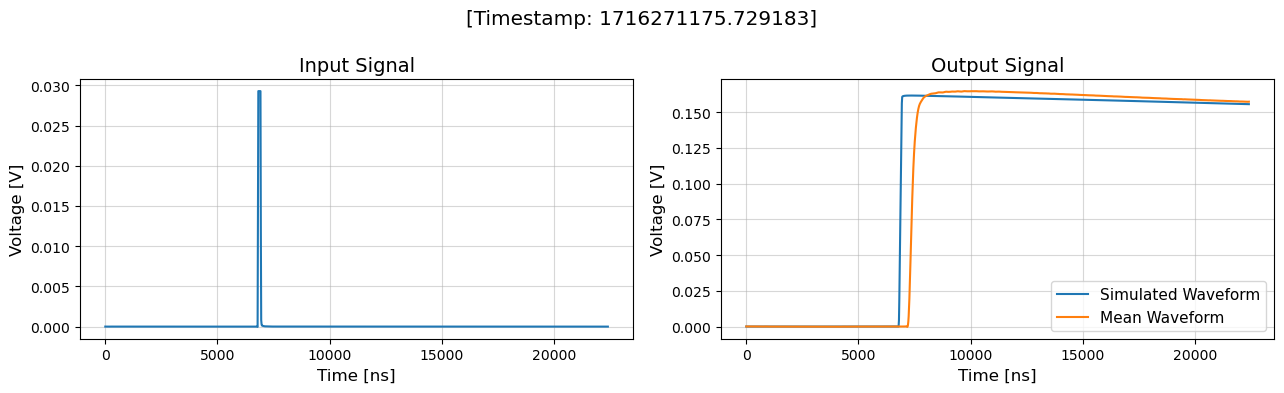

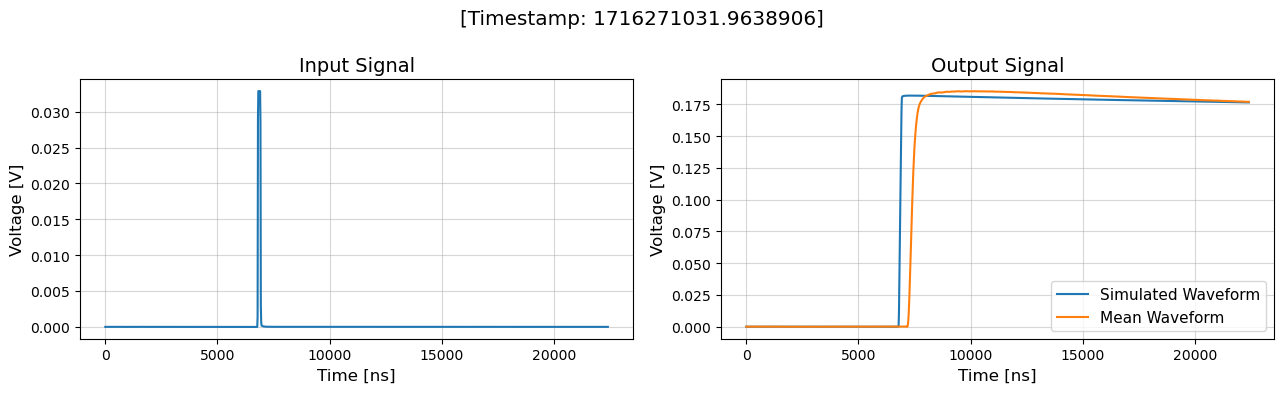

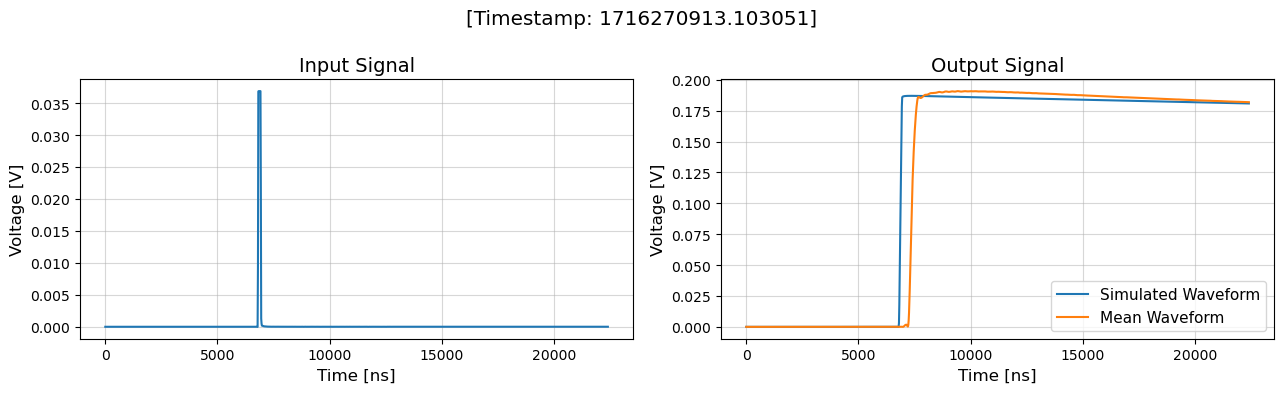

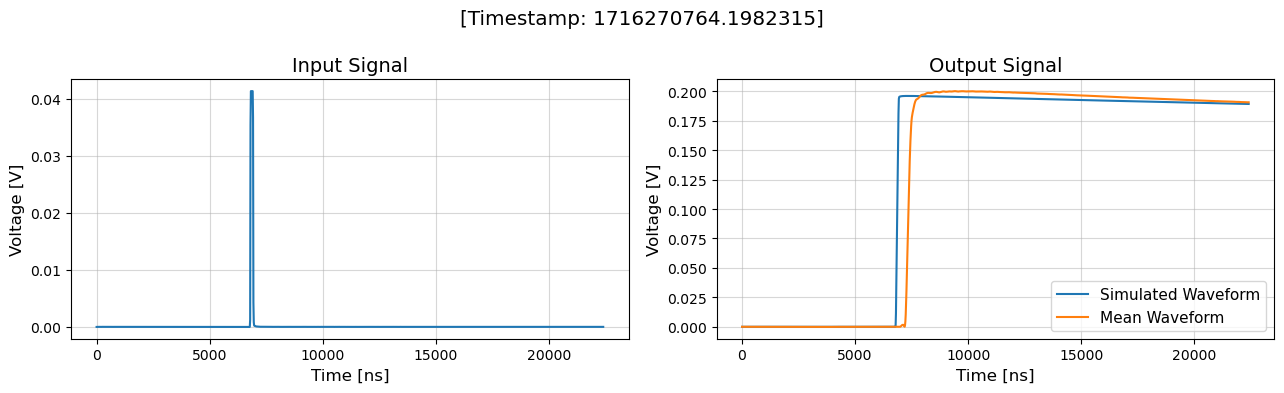

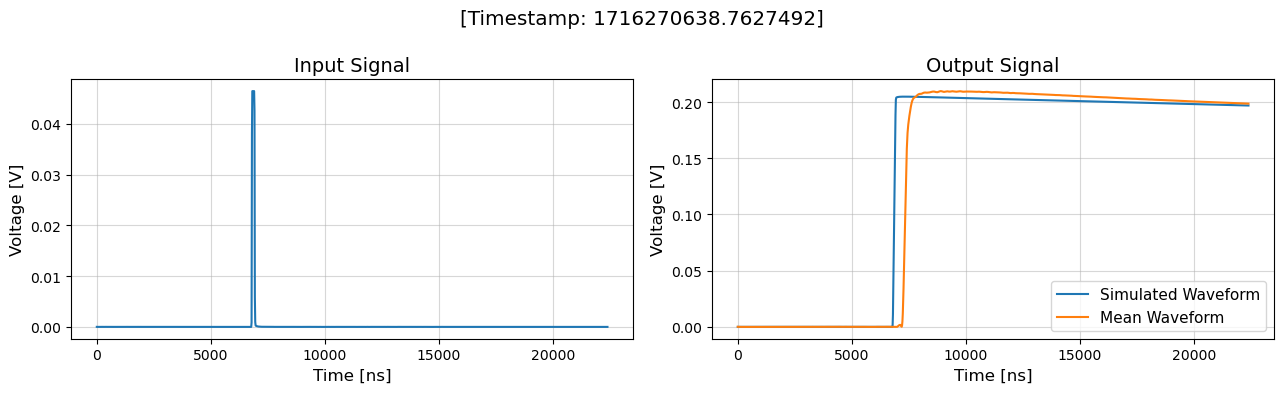

In [13]:
simulation_results = np.zeros((14,len(scaled_df['signal'][0])))
conv_factors = []
sim_ampls = []
wf_ampls = []

dc_bias=-3.52

for i in range(len(signal_amplitude)):
    result, sim_amp, wf_ampl, A = validation_test(i,dc_bias=dc_bias)
    simulation_results[i:]=result
    conv_factors.append(A)
    sim_ampls.append(sim_amp)
    wf_ampls.append(wf_ampl)

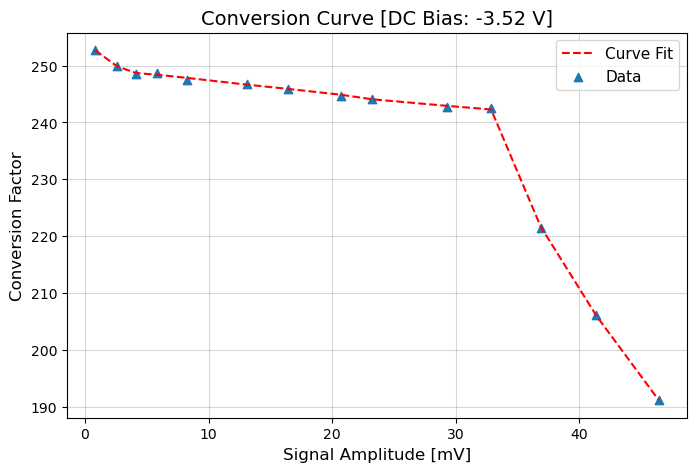

In [14]:
conversion_curve = UnivariateSpline(signal_amplitude,conv_factors, s=0.5)

plt.figure(figsize=(8,5))
plt.title(f'Conversion Curve [DC Bias: {dc_bias} V]')
plt.plot(signal_amplitude*1e3,conversion_curve(signal_amplitude), 'r--', label='Curve Fit')
plt.scatter(signal_amplitude*1e3,conv_factors, marker='^', label='Data')
plt.xlabel('Signal Amplitude [mV]')
plt.ylabel('Conversion Factor')
plt.legend()
plt.grid(alpha=0.5)

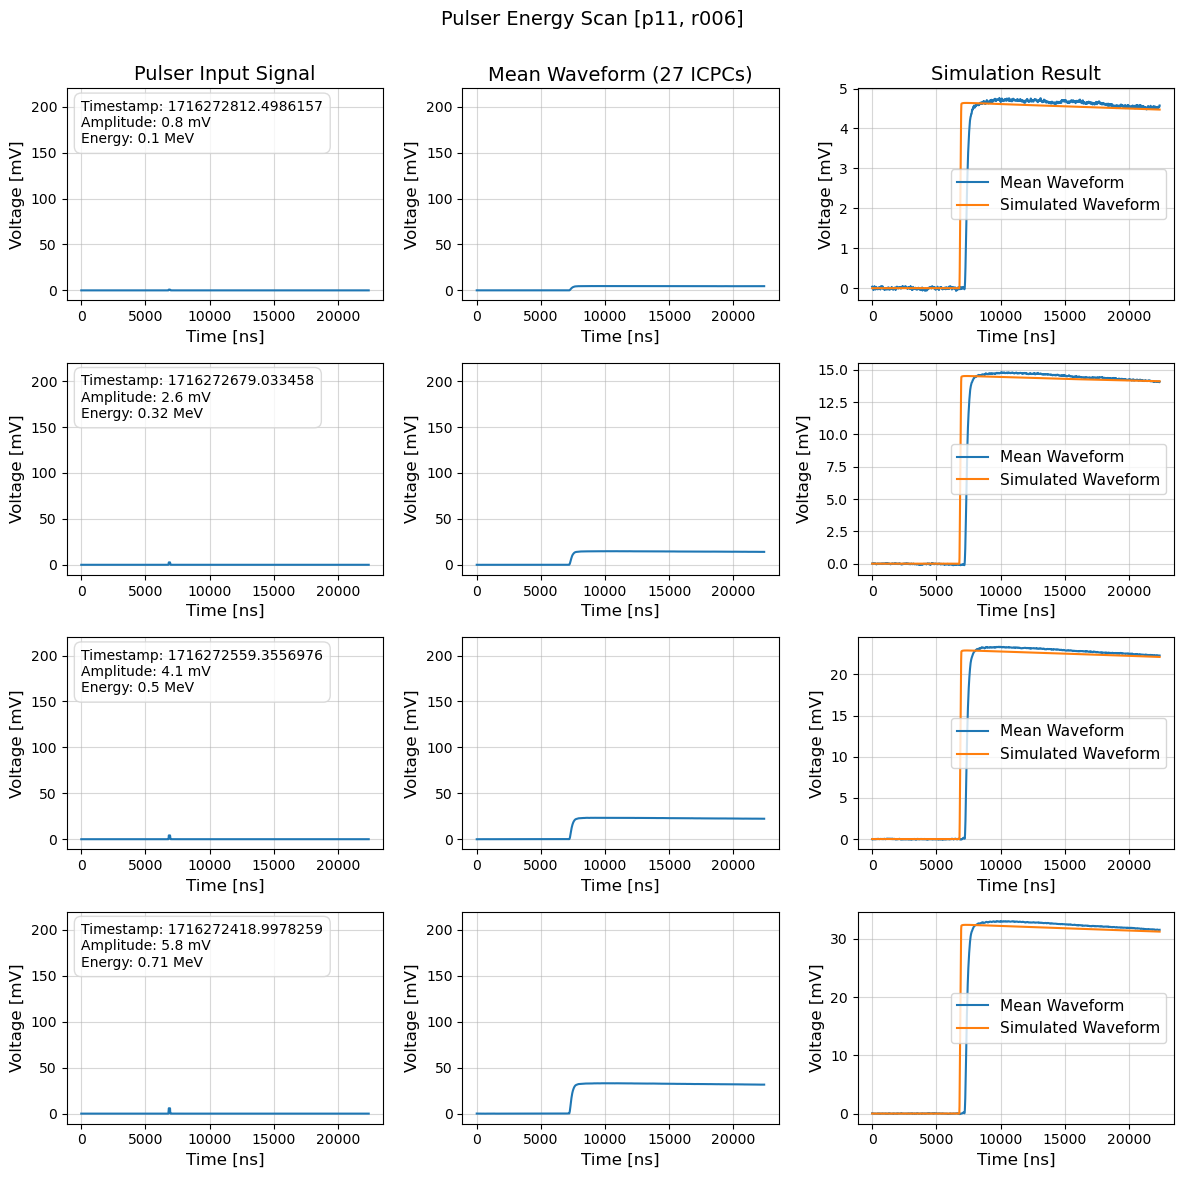

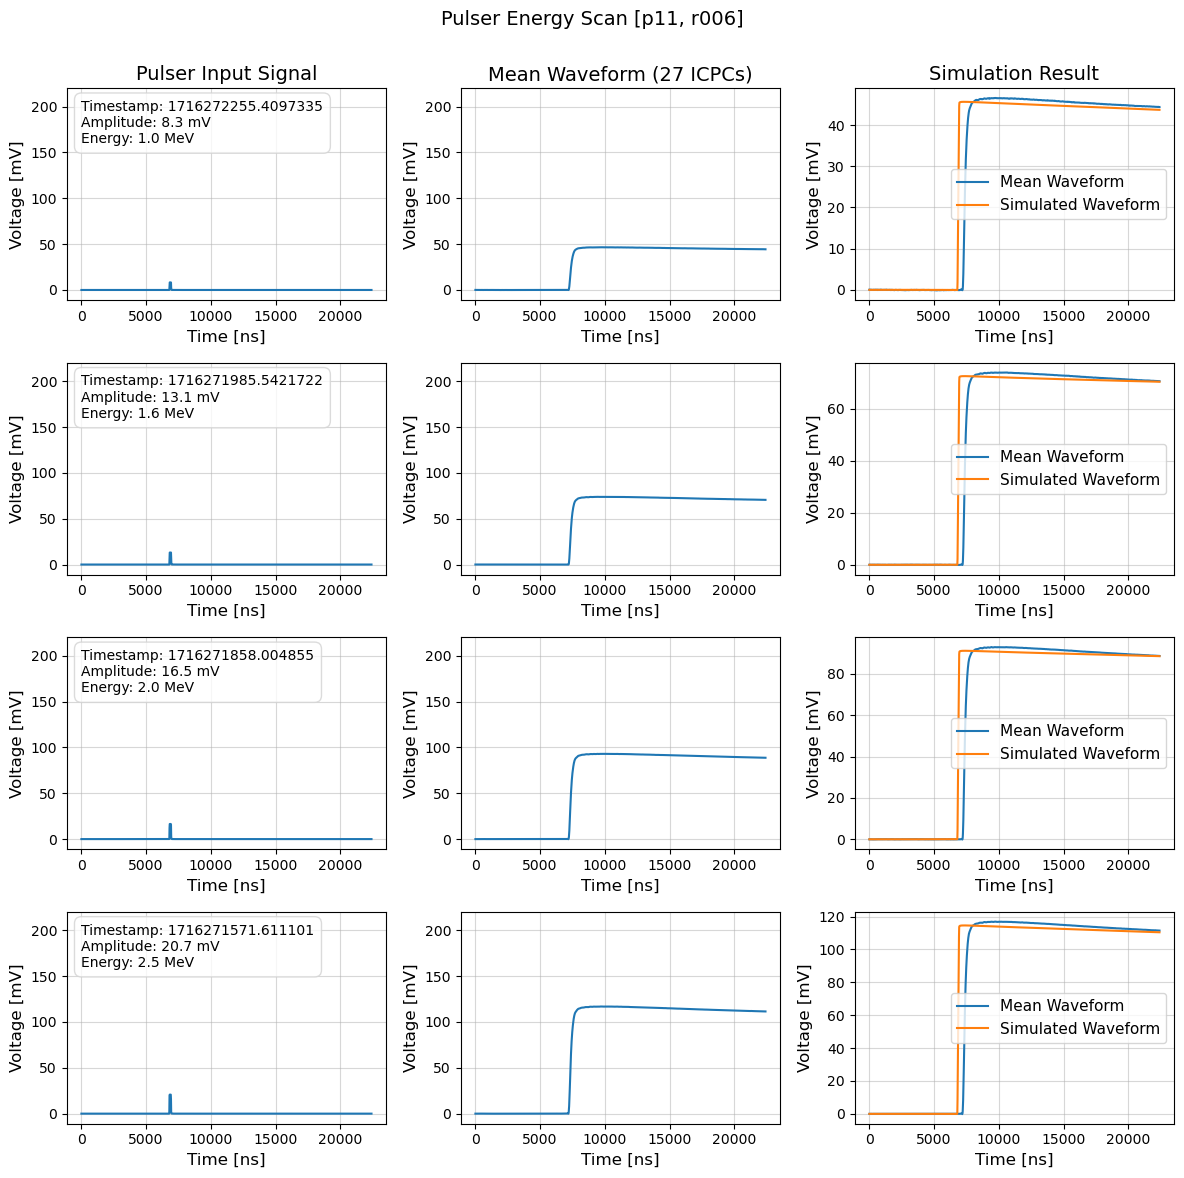

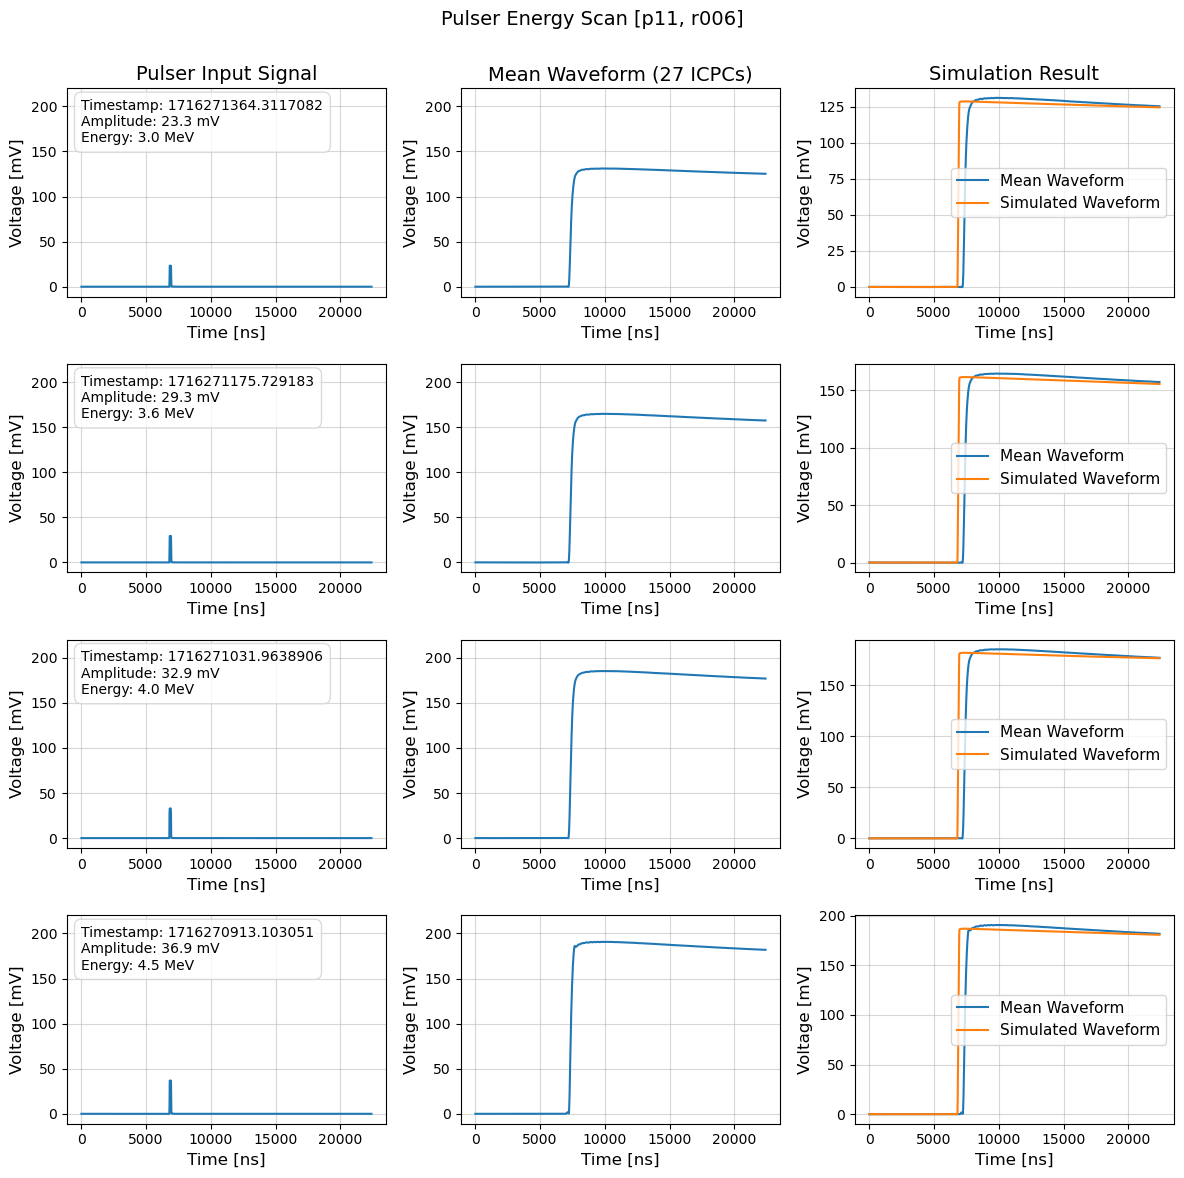

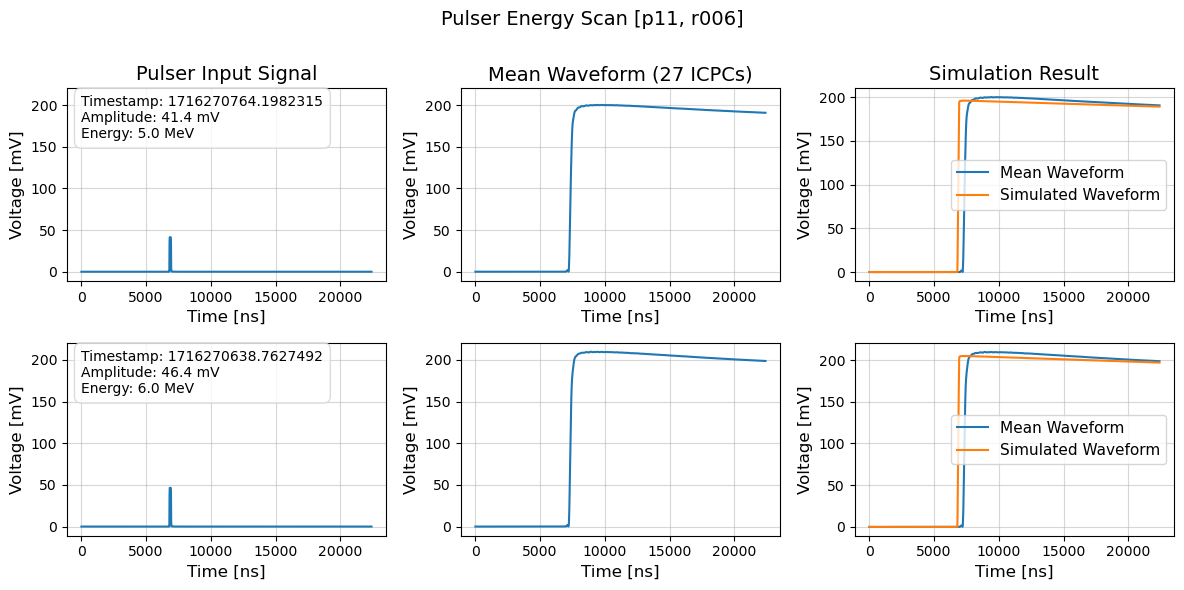

In [15]:
# Define the desired row splits
row_splits = [4, 4, 4, 2]

start_row = 0  # to keep track of the global index
for fig_index, n_rows in enumerate(row_splits):
    end_row = start_row + n_rows
    fig, axs = plt.subplots(n_rows, 3, figsize=(12, 3 * n_rows))
    fig.suptitle(f'Pulser Energy Scan [p11, r006]', fontsize=14)
    plt.subplots_adjust(top=0.98)
    
    # Loop over the subset for this figure
    for row_idx, energy in enumerate(energies[start_row:end_row]):
        i = row_idx + start_row  # absolute index in your data
        
        # Input Signal Plot
        if row_idx == 0:
            axs[row_idx, 0].set_title('Pulser Input Signal')
        axs[row_idx, 0].plot(scaled_df.iloc[i]['time_signal'], 
                             np.array(scaled_df.iloc[i]['signal']) * 1e3)
        axs[row_idx, 0].set_xlabel('Time [ns]')
        axs[row_idx, 0].set_ylabel('Voltage [mV]')
        axs[row_idx, 0].set_ylim([-11, 0.22 * 1e3])
        axs[row_idx, 0].grid(alpha=0.5)
        axs[row_idx, 0].text(1, 0.16 * 1e3, 
            f'Timestamp: {scaled_df.iloc[i]["time_stamp_signal"]}\n'
            f'Amplitude: {round(signal_amplitude[i]*1e3, 1)} mV\n'
            f'Energy: {energy} MeV', 
            fontsize=10,
            bbox=dict(facecolor="white", edgecolor="lightgray", boxstyle="round,pad=0.5", alpha=0.8))
        
        # Mean Waveform Plot
        if row_idx == 0:
            axs[row_idx, 1].set_title('Mean Waveform (27 ICPCs)')
        axs[row_idx, 1].plot(scaled_df.iloc[i]['time_waveform'], 
                             np.array(scaled_df.iloc[i]['waveform']) * 1e3)
        axs[row_idx, 1].set_xlabel('Time [ns]')
        axs[row_idx, 1].set_ylabel('Voltage [mV]')
        axs[row_idx, 1].set_ylim([-11, 0.22 * 1e3])
        axs[row_idx, 1].grid(alpha=0.5)
        
        # Simulation Result Plot
        if row_idx == 0:
            axs[row_idx, 2].set_title('Simulation Result')
        axs[row_idx, 2].plot(scaled_df.iloc[i]['time_waveform'], 
                             np.array(scaled_df.iloc[i]['waveform']) * 1e3, 
                             label='Mean Waveform')
        axs[row_idx, 2].plot(scaled_df.iloc[i]['time_waveform'], 
                             np.array(simulation_results[i]) * 1e3, 
                             label='Simulated Waveform')
        axs[row_idx, 2].set_xlabel('Time [ns]')
        axs[row_idx, 2].set_ylabel('Voltage [mV]')
        axs[row_idx, 2].legend()
        axs[row_idx, 2].grid(alpha=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()  # Display the current figure
    
    start_row = end_row  # update the start_row for the next figure


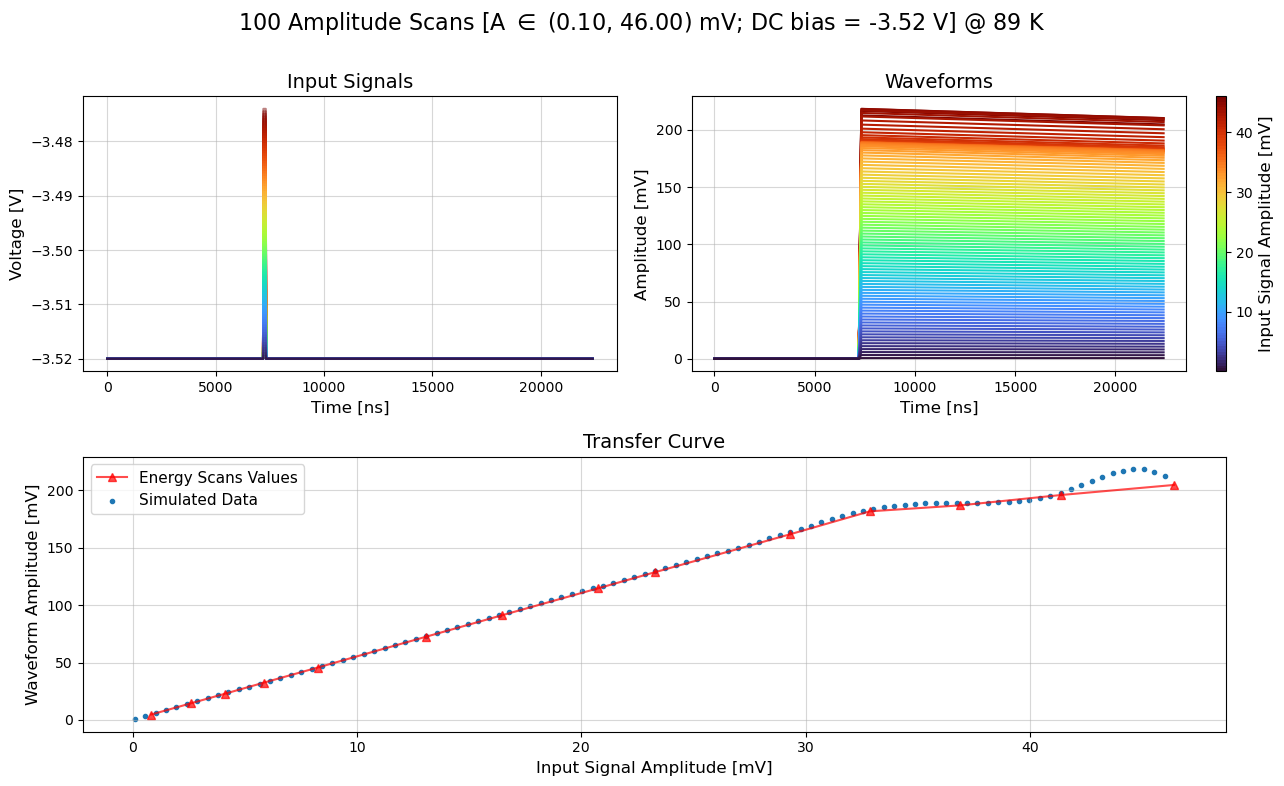

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


time = np.array([i * 1e-9 for i in scaled_df['time_signal'][0]])
dt = time[1] - time[0]

def delta_signal(time, amplitude, start, duration):
    signal = np.zeros_like(time)
    signal[start:start+duration] = amplitude
    return signal

# Create amplitude values (reverse order for color mapping consistency)
amplitudes = np.linspace(0.046, 0.0001, 100)
dc_bias = -3.52
toy_signals = []
sim_waveforms = []

for a in amplitudes:
    input_signal = delta_signal(time, 1, 450, 8)
    signal = input_signal * a + dc_bias
    output = total_transfer_loaded(signal)
    integrated_signal = integrate_signal_2(C_f=400e-15, R_f=1e9, input_signal=output, dt=dt, decay=True)
    conversion_factor = conversion_curve(a)
    final_out = np.array([i * conversion_factor for i in integrated_signal])
    toy_signals.append(signal)
    sim_waveforms.append(final_out)

sim_amplitudes_converted = np.array([np.max(i) for i in sim_waveforms])


cmap_name = "turbo"


norm = plt.Normalize(min(amplitudes)*1e3, max(amplitudes)*1e3)
cmap = cm.get_cmap(cmap_name, len(amplitudes)).reversed()
cmap_2 = cmap.reversed()

# Create the figure and a flexible grid layout
fig = plt.figure(figsize=(13, 8))

# Set font sizes
plt.rcParams.update({
    'font.size': 12,          # Default text size
    'axes.titlesize': 14,     # Title size
    'axes.labelsize': 12,     # Axis label size
    'xtick.labelsize': 10,    # X-tick label size
    'ytick.labelsize': 10,    # Y-tick label size
    'legend.fontsize': 11     # Legend size
})
title_size = 16

plt.suptitle(
    f'100 Amplitude Scans [A $\in$ ({min(amplitudes)*1e3:.2f}, {max(amplitudes)*1e3:.2f}) mV; DC bias = {np.round(dc_bias,3)} V] @ 89 K',
    fontsize=16)

gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input Signals')
for idx, signal in enumerate(toy_signals):
    color = cmap(idx)
    ax1.plot(time * 1e9, signal, color=color, alpha=0.5)
ax1.grid(alpha=0.5)
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Voltage [V]')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Waveforms')
for idx, (a, waveform) in enumerate(zip(amplitudes, sim_waveforms)):
    color = cmap(idx)
    ax2.plot(time * 1e9, waveform*1e3, color=color)
ax2.grid(alpha=0.5)
ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Amplitude [mV]')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.3)
sm = plt.cm.ScalarMappable(cmap=cmap_2, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Input Signal Amplitude [mV]')

ax3 = fig.add_subplot(gs[1, :])
ax3.set_title('Transfer Curve')
ax3.plot(signal_amplitude*1e3, waveform_amplitude*1e3, '^-', color='red', label='Energy Scans Values', alpha=0.7)
for i, a in enumerate(amplitudes):
    if i == 0:
        ax3.scatter(a*1e3, np.max(sim_waveforms[i])*1e3, marker='.', color='tab:blue', label='Simulated Data')
    else:
        ax3.scatter(a*1e3, np.max(sim_waveforms[i])*1e3, marker='.', color='tab:blue')
ax3.grid(alpha=0.5)
ax3.set_xlabel('Input Signal Amplitude [mV]')
ax3.set_ylabel('Waveform Amplitude [mV]')
ax3.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [17]:
amplitude_scans_df = pd.DataFrame({'input_amplitude': amplitudes[::-1], 'simulated_waveform_amplitude': sim_amplitudes_converted[::-1], 
                                'simulated_waveform_amplitude_normalied_wrt_input': sim_amplitudes_converted[::-1]/amplitudes[::-1]}) 

amplitude_scans_df.to_csv('amplitude_scans.csv', index=False)

In [18]:
sim_waveforms_to_df = sim_waveforms[::-1]
toy_signals_to_df = toy_signals[::-1]
amplitudes_to_df = amplitudes[::-1]


scan_data = []

df_ampl_scan = pd.DataFrame([
    {
        'amplitude': j,
        'input_signal': np.array(toy_signals_to_df[i]), 
        'simulated_waveform': np.array(sim_waveforms_to_df[i]), 
        'normalized_waveform': np.array(sim_waveforms_to_df[i]) / j,
    }
    for i, j in enumerate(amplitudes_to_df)
])

df_ampl_scan.to_pickle('amplitude_scan_full_data.pkl')

In [19]:
df_ampl_scan = pd.read_pickle('amplitude_scan_full_data.pkl')
df_ampl_scan

,amplitude,input_signal,simulated_waveform,normalized_waveform
0,0.000100,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
1,0.000564,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
2,0.001027,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
3,0.001491,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
4,0.001955,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
...,...,...,...,...
95,0.044145,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
96,0.044609,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
97,0.045073,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
98,0.045536,"[-3.52, -3.52, -3.52, -3.52, -3.52, -3.52, -3....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."


In [20]:
type(df_ampl_scan['simulated_waveform'][0])

numpy.ndarray

In [21]:
ICPCs = ['V02160A', 'V02160B', 'V05261B', 'V05266A', 'V05266B', 'V05268B', 'V05612A', 'V07647A', 'V07647B', 'V04549A', 'V08682B', 'V08682A', 'V09372A', 'V09374A', 'V09724A', 'V02162B', 'V02166B', 'V04199A', 'V04545A', 'V07302B', 'V00048B', 'V00050A', 'V05268A', 'V00048A', 'V01240A', 'V05267A', 'V05612B']

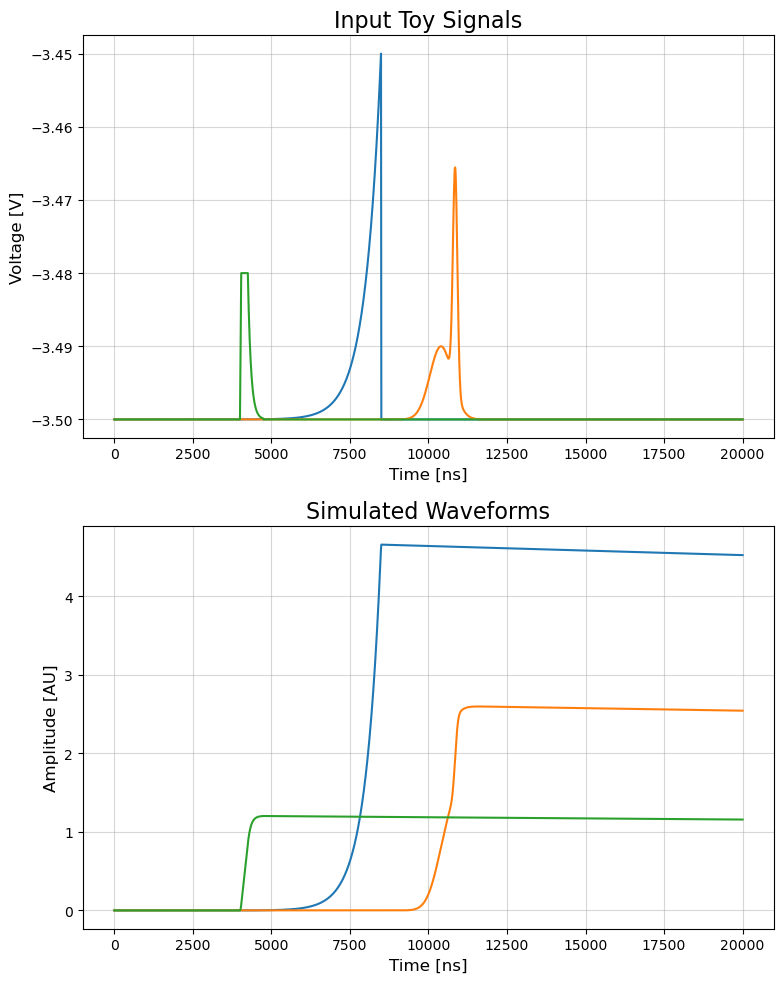

In [22]:
duration = 20000e-9
dt = 10e-9
t= np.arange(0, duration, dt)

#-------------------------------------------------------------------------------------

amplitude = 0.05
signal1 = generate_impulse_signal(t,
                                    rise_time=850,
                                    growth_rate=0.02,
                                    peak_amplitude=amplitude,
                                    offset=-3.5,
                                    plateau=False,
                                    lamb=0.5e6
                                    ) 

signal_out1 = total_transfer_loaded(signal1)
waveform1 = integrate_signal_2(R_f=1e9,C_f=400e-15,input_signal=signal_out1,dt=dt)
#-------------------------------------------------------------------------------------

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/sigma**2)

s1=gauss(t,10850e-9,100e-9,0.03)
s2=gauss(t,10400e-9,500e-9,0.01)
signal2 = (s1+s2) - 3.5

signal_out2 = total_transfer_loaded(signal2)
waveform2 = integrate_signal_2(R_f=1e9,C_f=400e-15,input_signal=signal_out2,dt=dt)
#-------------------------------------------------------------------------------------

signal3= generate_trapezoidal_signal(t,
                                    amplitude=0.02,
                                    rise_time=50e-9,
                                    flat_top_time=200e-9,
                                    fall_time=500e-9,
                                    exponential_decay=True
                                    ) -3.5


signal_out3 = total_transfer_loaded(signal3)
waveform3 = integrate_signal_2(R_f=1e9,C_f=400e-15,input_signal=signal_out3,dt=dt)



plt.figure(figsize=(8,10))


plt.subplot(2,1,1)
plt.title('Input Toy Signals', fontsize=16)
plt.plot(t*1e9,signal1)
plt.plot(t*1e9,signal2)
plt.plot(t*1e9,signal3)
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.grid(alpha=0.5)

plt.subplot(2,1,2)
plt.title('Simulated Waveforms', fontsize=16)
plt.plot(t*1e9,waveform1*1e3)
plt.plot(t*1e9,waveform2*1e3)
plt.plot(t*1e9,waveform3*1e3)
plt.xlabel('Time [ns]')
plt.ylabel('Amplitude [AU]')
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

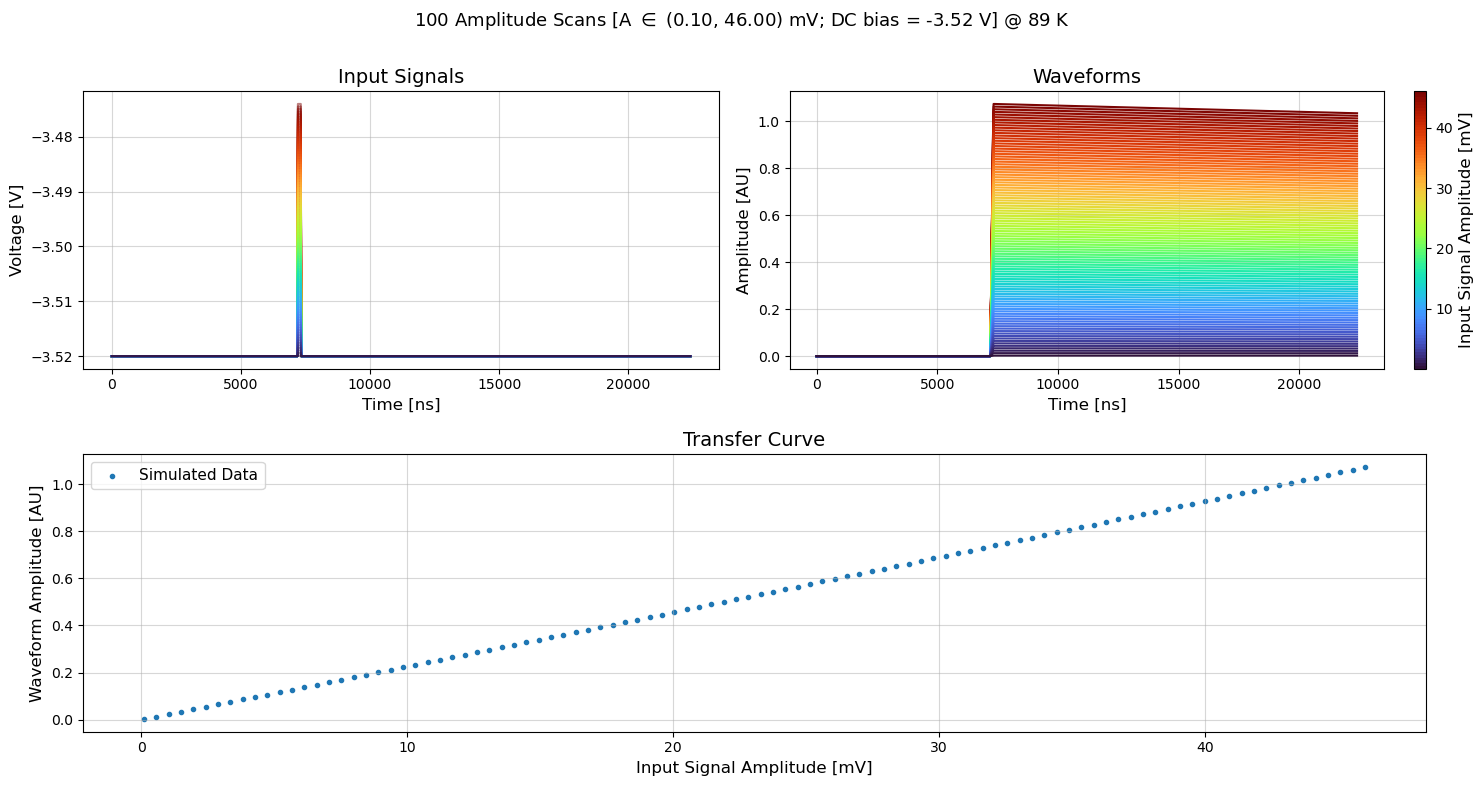

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


time = np.array([i * 1e-9 for i in scaled_df['time_signal'][0]])
dt = time[1] - time[0]

def delta_signal(time, amplitude, start, duration):
    signal = np.zeros_like(time)
    signal[start:start+duration] = amplitude
    return signal

# Create amplitude values (reverse order for color mapping consistency)
amplitudes = np.linspace(0.046, 0.0001, 100)
dc_bias = -3.52
toy_signals = []
sim_waveforms = []

for a in amplitudes:
    input_signal = delta_signal(time, 1, 450, 8)
    signal = input_signal * a + dc_bias
    output = total_transfer_loaded(signal)
    integrated_signal = integrate_signal_2(C_f=400e-15, R_f=1e9, input_signal=output, dt=dt, decay=True)
    conversion_factor = 1#conversion_curve(a)
    final_out = np.array([i * conversion_factor for i in integrated_signal])
    toy_signals.append(signal)
    sim_waveforms.append(final_out)

sim_amplitudes = np.array([np.max(i) for i in sim_waveforms])


cmap_name = "turbo"


norm = plt.Normalize(min(amplitudes)*1e3, max(amplitudes)*1e3)
cmap = cm.get_cmap(cmap_name, len(amplitudes)).reversed()
cmap_2 = cmap.reversed()

# Create the figure and a flexible grid layout
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    f'100 Amplitude Scans [A $\in$ ({min(amplitudes)*1e3:.2f}, {max(amplitudes)*1e3:.2f}) mV; DC bias = {np.round(dc_bias,3)} V] @ 89 K',
    fontsize=13)

gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input Signals')
for idx, signal in enumerate(toy_signals):
    color = cmap(idx)
    ax1.plot(time * 1e9, signal, color=color, alpha=0.5)
ax1.grid(alpha=0.5)
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Voltage [V]')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Waveforms')
for idx, (a, waveform) in enumerate(zip(amplitudes, sim_waveforms)):
    color = cmap(idx)
    ax2.plot(time * 1e9, waveform*1e3, color=color)
ax2.grid(alpha=0.5)
ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Amplitude [AU]')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.3)
sm = plt.cm.ScalarMappable(cmap=cmap_2, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Input Signal Amplitude [mV]')

ax3 = fig.add_subplot(gs[1, :])
ax3.set_title('Transfer Curve')
#ax3.plot(signal_amplitude*1e3, waveform_amplitude*1e3, '^-', color='red', label='Energy Scans Values', alpha=0.7)
for i, a in enumerate(amplitudes):
    if i == 0:
        ax3.scatter(a*1e3, np.max(sim_waveforms[i])*1e3, marker='.', color='tab:blue', label='Simulated Data')
    else:
        ax3.scatter(a*1e3, np.max(sim_waveforms[i])*1e3, marker='.', color='tab:blue')
ax3.grid(alpha=0.5)
ax3.set_xlabel('Input Signal Amplitude [mV]')
ax3.set_ylabel('Waveform Amplitude [AU]')
ax3.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


-------